In [1]:
import pandas as pd
path = r'https://raw.githubusercontent.com/aztgmb/algo_trading_task/main/BTCUSD%20-%20Bitstamp_BTCUSD_1h.csv'
df = pd.read_csv(path)

In [2]:
df=df.loc[df['date']>='2020-01-01 0:00:00']
df=df.drop(['unix','symbol','Volume BTC','Volume USD'],axis=1)

In [3]:
df['date']=pd.to_datetime(df['date'])

In [4]:
def candles(df):
    candles_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    candles_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    for i in range(len(df)):
        if i == 0:
            candles_df.iat[0, 0] = df['open'].iloc[0]
        else:
            candles_df.iat[i, 0] = (candles_df.iat[i-1, 0] + candles_df.iat[i-1, 3]) / 2
    candles_df['high'] = candles_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    candles_df['low'] = candles_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)
    return candles_df

In [5]:
candles=candles(df)

In [6]:
candles['date']=df['date']
candles=candles.set_index('date')
candles=candles.sort_index()

In [7]:
def sma(data, n):
    sma = data.rolling(window = n).mean()
    return pd.DataFrame(sma)

n = [14, 36]
for i in n:
    candles[f'sma_{i}'] = sma(candles['close'], i)

In [8]:
candles1=candles.dropna(axis=0)
candles1

,open,high,low,close,sma_14,sma_36
date,,,,,,
2020-01-02 11:00:00,7116.01,7144.920,7116.006782,7129.0000,7135.309286,7173.303333
2020-01-02 12:00:00,7104.46,7142.310,7104.461064,7127.5525,7130.811786,7172.424792
2020-01-02 13:00:00,7091.65,7140.210,7081.400000,7117.2725,7126.955893,7170.823403
2020-01-02 14:00:00,7065.33,7139.950,7065.326756,7117.9725,7122.677321,7168.343056
2020-01-02 15:00:00,7015.54,7131.750,7015.538513,7115.1150,7118.558929,7165.752431
...,...,...,...,...,...,...
2021-06-28 20:00:00,34571.2,34801.180,34287.300000,34559.3600,34483.696607,33910.647708
2021-06-28 21:00:00,34466.6,34831.620,34466.603750,34675.8275,34470.771250,33962.748750
2021-06-28 22:00:00,34455.1,34628.690,34214.000000,34478.1425,34435.143571,34014.350694


In [9]:
import numpy as np
def strat(data, sma_short, sma_long):
    sma1 = sma_short
    sma2 = sma_long
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0
    for i in range(len(data)):
        if sma1[i] > sma2[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        elif sma2[i] > sma1[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                sma_signal.append(-1)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(0)
    return buy_price, sell_price, sma_signal

buy_price, sell_price, signal = strat(candles1['close'], candles1['sma_14'], candles1['sma_36'])

In [10]:
data1=[buy_price, sell_price, signal]
df_new=pd.DataFrame(data1)
df_new=df_new.T
df_new = df_new.rename(columns={0:'buy_price',1:'sell_price',2:'signal'})
df_new.index=candles1.index
df_new=df_new.loc[df_new['signal']!=0]
df_new

,buy_price,sell_price,signal
date,,,
2020-01-02 11:00:00,NaN,7129.0000,-1.0
2020-01-03 11:00:00,7317.0575,NaN,1.0
2020-01-04 20:00:00,NaN,7318.9850,-1.0
2020-01-05 01:00:00,7411.8625,NaN,1.0
2020-01-09 00:00:00,NaN,7993.4925,-1.0
...,...,...,...
2021-06-23 02:00:00,33961.0175,NaN,1.0
2021-06-24 03:00:00,NaN,32584.5175,-1.0
2021-06-24 18:00:00,35006.7500,NaN,1.0


In [11]:
df_new['profit_usd']=pd.Series()
df_new['profit_btc']=pd.Series()
df_new['profit_pct']=pd.Series()
for i in range(1,len(df_new['signal']+1)):
  if df_new['signal'][i-1]==-1.0 and df_new['signal'][i]==1.0:
    df_new['profit_usd'][i]=(df_new['sell_price'][i-1]-df_new['buy_price'][i])*0.1
    df_new['profit_btc'][i]=df_new['profit_usd'][i]/df_new['buy_price'][i]
    df_new['profit_pct'][i]=(((df_new['sell_price'][i-1]-df_new['buy_price'][i])*0.1)/(df_new['buy_price'][i]*0.1))*100
  if df_new['signal'][i-1]==1.0 and df_new['signal'][i]==-1.0:
    df_new['profit_usd'][i]=(df_new['sell_price'][i]-df_new['buy_price'][i-1])*0.1
    df_new['profit_btc'][i]=df_new['profit_usd'][i]/df_new['buy_price'][i-1]
    df_new['profit_pct'][i]=(((df_new['sell_price'][i]-df_new['buy_price'][i-1])*0.1)/(df_new['buy_price'][i-1]*0.1))*100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
df_new['running_total_btc']=df_new['profit_btc'].cumsum()
df_new['running_total_usd']=df_new['profit_usd'].cumsum()
df_new['drawdown_btc']=(df_new['running_total_btc']-df_new['running_total_btc'].cummax())/df_new['running_total_btc'].cummax()*100
df_new['drawdown_usd']=(df_new['running_total_usd']-df_new['running_total_usd'].cummax())/df_new['running_total_usd'].cummax()*100

In [13]:
# profit, %
profit=df_new['profit_pct'].sum()
# MDD, %
mdd_btc=df_new['drawdown_btc'].min()
mdd_usd=df_new['drawdown_usd'].min()
# deals number
n_total=df_new.shape[0]
# share of profitable deals, %
df_new_prof=df_new.loc[df_new['profit_pct']>0]
n_profit=df_new_prof.shape[0]
s_profit=n_profit/n_total*100
# share of unprofitable deals, %
df_new_unprof=df_new.loc[df_new['profit_pct']<=0]
n_unprofit=df_new_unprof.shape[0]
s_unprofit=n_unprofit/n_total*100
# average profitale deal, %
avg_profit=df_new_prof['profit_pct'].mean()
# average non-profitable deal, %
avg_unprofit=df_new_unprof['profit_pct'].mean()
# Longest streak of unprofitable deals
df_new['neg']=df_new['profit_btc']<0
streak=(~df_new['neg']).cumsum()[df_new['neg']].value_counts().max()
# Recovery factor
df_new['drawdown_usd_rf']=df_new['running_total_usd']-df_new['running_total_usd'].cummax()
rf=df_new['profit_usd'].sum()/df_new['drawdown_usd_rf'].min()

In [14]:
print('profit, %  ' + str(round(profit,2)))
print('MDD, %  ' + str(round(mdd_usd,2)))
print('deals number  ' + str(n_total))
print('share of profitable deals, %  ' + str(round(s_profit,2)))
print('share of unprofitable deals, %  ' + str(round(s_unprofit,2)))
print('average profitable deal, %  ' + str(round(avg_profit,2)))
print('average unprofitable deal, %  ' + str(round(avg_unprofit,2)))
print('longest streak of unprofitable deals  ' + str(round(streak,2)))
print('recovery factor  ' + str(round(rf,2)))

profit, %  78.54
MDD, %  -269.52
deals number  452
share of profitable deals, %  31.19
share of unprofitable deals, %  68.58
average profitable deal, %  4.53
average unprofitable deal, %  -1.81
longest streak of unprofitable deals  10
recovery factor  0.27


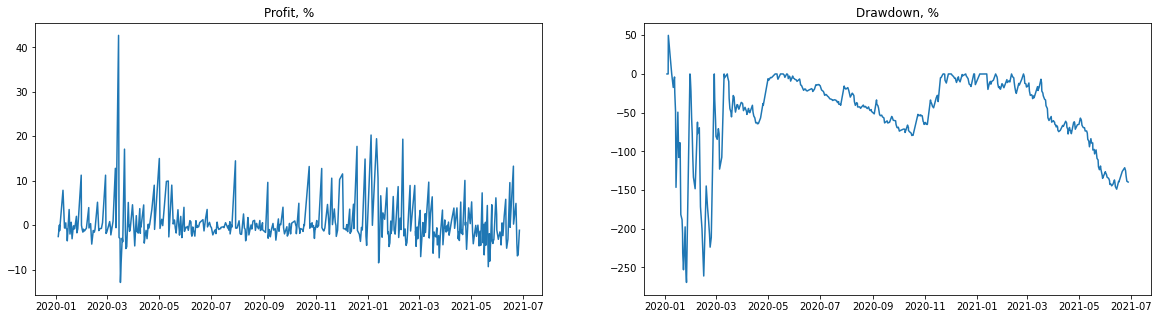

In [27]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
ax1.plot(df_new['profit_pct'])
ax2.plot(df_new['drawdown_usd'])
ax1.title.set_text('Profit, %')
ax2.title.set_text('Drawdown, %')